## Import Require Library

In [24]:
import duckdb
import geopandas as gp
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
import time
import numpy as np

## Load Data

In [2]:
spatial_data = gp.read_file('../data/Peta Bapernas - Kab/DESA_83218 - Kab.TAB')
poi_data = pd.read_csv('../data/poi/poi_data_from_osm.csv')

C:\Users\diasn\AppData\Local\Temp\ipykernel_37956\2693790467.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_data = pd.read_csv('../data/poi/poi_data_from_osm.csv')


In [ ]:
spatial_data.info()

In [ ]:
poi_data.head(5)

## Intersection with GeoPandas

In [10]:
def within_geopandas(df_point, df_polygon):
    # Create Point geometry from longitude and latitude
    geometry = [Point(lon, lat) for lon, lat in zip(df_point['longitude'], df_point['latitude'])]
    df_point = gp.GeoDataFrame(df_point, geometry=geometry, crs="EPSG:4326")  # assuming lat/lon is in WGS84 (EPSG:4326)
    gdf_joined = gp.sjoin(df_point, df_polygon, how="inner", predicate="within")
    return gdf_joined

## Intersection with DuckDB

In [11]:
def within_duckdb(df_point, df_polygon):
    
    points_df = df_point.copy()
    polygons_df = df_polygon.copy()
    
    # Convert polygons and points to WKT format (as text)
    polygons_df['geometry'] =  polygons_df['geometry'].apply(lambda geom: geom.wkt)
    
    # Connect to DuckDB
    con = duckdb.connect()
    
    # Register the DataFrames as tables in DuckDB
    con.register('points', points_df)
    con.register('polygons', polygons_df)
    
    query = """
        INSTALL spatial;
        LOAD spatial;
        SELECT *
        FROM points AS p
        JOIN polygons AS poly
        ON ST_Within(ST_Point(longitude, latitude), ST_GeomFromText(poly.geometry)) = TRUE
    """

    result = con.execute(query).fetchdf()
    return result

## Comparison the Performance on Sampling of Data

In [38]:
len_sample = list(range(0, 100001, 1000))

df_result_all = []
for sample_num in len_sample:
    #sampling point
    sampled_df = poi_data.sample(n=sample_num)
    
    #calculate time for geopandas
    start_time = time.time()
    result_geopandas = within_geopandas(sampled_df, spatial_data)
    end_time = time.time()
    exec_time_geopandas = end_time - start_time

    #calculate time for duckdb
    start_time = time.time()
    result_duckdb = within_geopandas(sampled_df, spatial_data)
    end_time = time.time()
    exec_time_duckdb = end_time - start_time


    #create dataframe result 
    df_result = pd.DataFrame(columns=["sample_num"])
    df_result.loc[0] = sample_num
    df_result["geopandas_times"] = exec_time_geopandas
    df_result["duckdb_times"] = exec_time_duckdb

    df_result_all.append(df_result)

df_result_all = pd.concat(df_result_all).reset_index(drop=True)

In [39]:
df_result_all

,sample_num,geopandas_times,duckdb_times
0,0,0.090279,0.090708
1,1000,0.330372,0.311671
2,2000,0.403071,0.404670
3,3000,0.470399,0.526541
4,4000,0.527288,0.486954
...,...,...,...
96,96000,3.879019,4.251626
97,97000,4.125342,3.521543
98,98000,4.244328,3.881876
99,99000,4.096719,3.911238


In [40]:
df = df_result_all.copy()

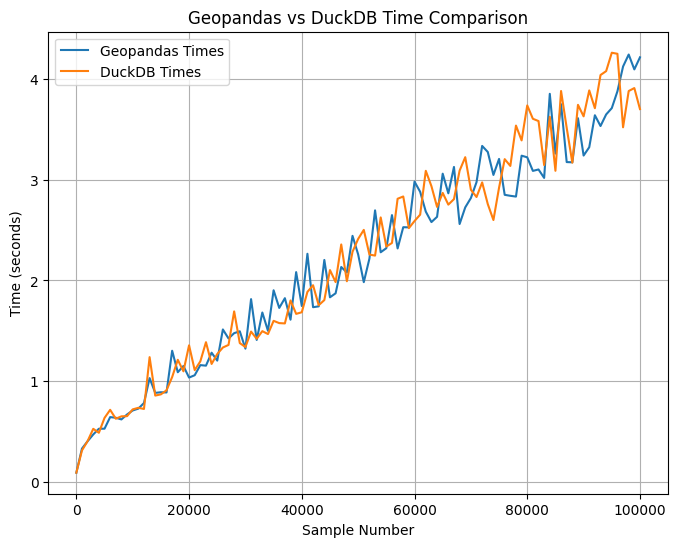

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df['sample_num'], df['geopandas_times'], label='Geopandas Times')
plt.plot(df['sample_num'], df['duckdb_times'], label='DuckDB Times')

# Add titles and labels
plt.title('Geopandas vs DuckDB Time Comparison')
plt.xlabel('Sample Number')
plt.ylabel('Time (seconds)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [44]:
df.to_csv("../data/export/geopandas_duckdb_time_comparison.csv", index = False)